# Current-voltage curves calculated with EGDM with image force corrections

This example reproduces drift-diffusion calculations from J. J. M. van der Holst, M. A. Uijttewaal, B. Ramachandhran, R. Coehoorn, P. A. Bobbert, [Modeling and analysis of the three-dimensional current density in sandwich-type single-carrier devices of disordered organic semiconductors](https://doi.org/10.1103/PhysRevB.79.085203), Physical Review B 79, 085203 (2009).

In [1]:
%matplotlib inline

import matplotlib.pylab as plt
import io
import numpy as np
from oedes import *

In [2]:
def egdmholeonly(L, image_force=True, z=1):
    m = models.BaseModel()
    mesh = fvm.mesh1d(L)
    m.poisson = Poisson(mesh)
    m.poisson.bc = [models.AppliedVoltage(
        boundary) for boundary in mesh.boundaries]
    impl = functions.gdos.UnivariateInterpolatedGaussFermiFactory(
        functions.gdos.defaultImpl)
    models.add_transport(
        m,
        mesh,
        z,
        'charge',
        dos_class=lambda: models.egdm.GaussianDOS(impl=impl))
    m.species[0].bc = [models.FermiLevelEqualElectrode(
        b, image_force=image_force) for b in mesh.boundaries]
    m.species_v_D['charge'] = m.species_dos['charge'].v_D
    m.setUp()
    return m

In [3]:
default_params = {
    'T': 298.,
    'epsilon_r': 3.,
    'charge.N0': 1.6e-9**-3.,
    #'hole.mu':1e-9,
    'charge.level': 0.,
    'electrode0.workfunction': 0,
    'electrode1.workfunction': 0,
    'electrode0.voltage': 0,
    'electrode1.voltage': 0.
}

In [4]:
def figiv(sigmaeV, mu0, maxv, L, n=41, sign=1, z=1):
    params = default_params.copy()
    models.egdm.egdm_params_simple(
        params,
        'charge',
        sigmaeV /
        functions.ThermalVoltage(
            params['T']),
        1.6e-9,
        mu0)
    m = egdmholeonly(L, image_force=True, z=z)
    for pbar in setparam(params, 'charge.level', np.linspace(0., 1., 4)):
        c = context(m)
        for p in setparam(
            pbar,
            'electrode0.voltage',
            sign *
            np.logspace(
                np.log10(maxv) -
                2,
                np.log10(maxv),
                n)):
            c.solve(p)
        v, j = c.teval('electrode0.voltage', 'J')
        testing.store(j, rtol=1e-4)
        plt.plot(v, sign * j, label='$\Delta$ = %s eV' % pbar['charge.level'])
    plt.yscale('log')
    plt.xscale('log')
    plt.title(r'L=%s nm, $\sigma$=%s eV' % (L * 1e9, sigmaeV))
    plt.show()

In [5]:
def figib(sigmaeV=None, mu0=None, L=22e-9, n=76, sign=1, z=1):
    params = default_params.copy()
    models.egdm.egdm_params_simple(
        params,
        'charge',
        sigmaeV /
        functions.ThermalVoltage(
            params['T']),
        1.6e-9,
        mu0)
    params['electrode0.voltage'] = sign * 2.
    for image in [False, True]:
        m = egdmholeonly(L, image_force=image, z=z)
        c = context(m)
        for p in setparam(params, 'charge.level', np.linspace(0., 1.5, n)):
            # print('.')
            c.solve(p)
        bar, j = c.teval('charge.level', 'J')
        testing.store(j, rtol=1e-4)
        plt.plot(bar, sign * j, label='image = %s' % image)
    plt.yscale('log')
    plt.title(r'L=%s nm, $\sigma$=%s eV' % (L * 1e9, sigmaeV))
    plt.show()

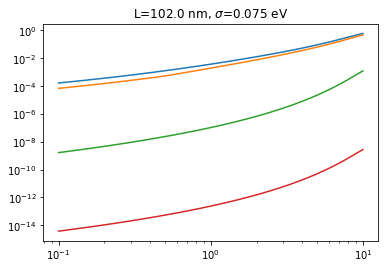

In [6]:
figiv(sigmaeV=0.075, mu0=4.8e-14, maxv=10., L=102e-9)

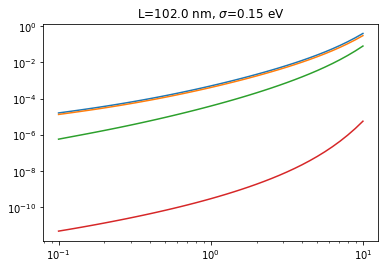

In [7]:
figiv(sigmaeV=0.150, mu0=1.6e-16, maxv=10., L=102e-9)

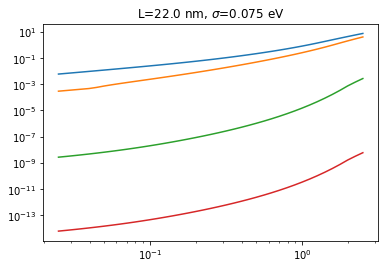

In [8]:
figiv(sigmaeV=0.075, mu0=4.8e-14, maxv=2.5, L=22e-9)

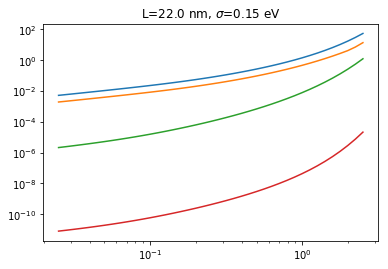

In [9]:
figiv(sigmaeV=0.150, mu0=1.6e-16, maxv=2.5, L=22e-9)

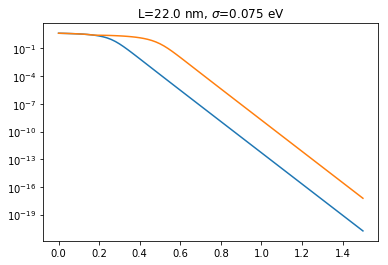

In [10]:
figib(sigmaeV=0.075, mu0=4.8e-14, L=22e-9)

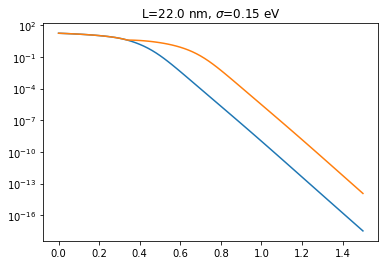

In [11]:
figib(sigmaeV=0.150, mu0=1.6e-16, L=22e-9)


---
This file is a part of __oedes__, an open source organic electronic device 
simulator. For more information, see <https://www.github.com/mzszym/oedes>.
